# <font color='#1a5276'> <b> <center> Callbacks </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data](#4)
5. [Model](#5)
6. [Built-in callbacks](#6) <br>
    6.1. [TensorBoard](#6.1) <br>
    6.2. [ModelCheckpoint](#6.2) <br>
    6.3. [EarlyStopping](#6.3) <br>
    6.4. [CSVLogger](#6.4) <br>
    6.5. [LearningRateScheduler](#6.5) <br>
    6.6. [ReduceLROnPlateau](#6.6) <br>
7. [Custom callbacks](#Overfitting-Detection) <br>
    7.1. [Simple Custom Callback](#7.1) <br>
    7.2. [Detect overfitting](#7.2) <br>
    7.3. [Visualize Predictions](#7.3) <br>
8. [References](#Conclusion)


<a name="1"> </a>
## <font color='blue'> 1. Introduction </font>

In Keras, Callback is a Python class designed to be subclassed for specific functionality.

It provides a set of methods that are called at various stages of:

- Training (batch/epoch start and end)
- Testing
- Predicting


Callbacks help monitor internal states and statistics during training.

The methods of callbacks can be triggered at different stages of:
- Training
- Evaluation
- Inference


Users can supply a list of callbacks to the following `tf.keras.Model` methods:

- fit()
- fit_generator()
- evaluate()
- evaluate_generator()
- predict()
- predict_generator()

**Note** The difference between fit() and fit_generator() in Keras lies in how they handle data input. model.fit() is used when the entire dataset fits into memory and it takes NumPy arrays or TensorFlow tensors as input; model.fit_generator() is used for large datasets that do not fit into memory and it takes a data generator (yielding batches) instead of NumPy arrays.

<a name="2"> </a>
## <font color='blue'> 2. Setup </font>

In [16]:
import os
import math
import io
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import (TensorBoard, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, CSVLogger, ReduceLROnPlateau)
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as IPyImage
import imageio

<a name="3"> </a>
## <font color='blue'> 3. Helper Functions </font>

In [10]:
# plot history
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [18]:
# Visualization utilities
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    plt.xticks([28*x+14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]: 
            t.set_color('green') 
        else: 
            t.set_color('red')
    plt.grid(None)

<a name="4"><a>
## <font color='blue'> 4 Data </font>

We will use a built-in TensorFlow dataset, specifically the Boston Housing dataset, which predicts house prices based on certain features.

In [6]:
# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()

type(x_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

<a name="5"> </a>
## <font color='blue'> 5. Model </font>

We will define a simple model to demonstrate the use of callbacks later.

In [8]:
# build and compile a model
def build_compile_model():
    # Build a Sequential model
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)),  # 13 features in input
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Output layer for regression (single continuous value)
    ])
    
    # Compile
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model


<a name="6"> </a>
## <font color='blue'> 6. Built-in Callbacks </font>

<a name="6.1"> </a>
### <font color='#2874a6'> 6.1. [TensorBoard](https://keras.io/api/callbacks/tensorboard/) </font>

Enable visualizations for TensorBoard.

In [11]:
!rm -rf logs

In [14]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [18]:
model_1 = build_compile_model()

history_1 = model_1.fit(x_train,
          y_train,
          epochs=50, 
          verbose=0,
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

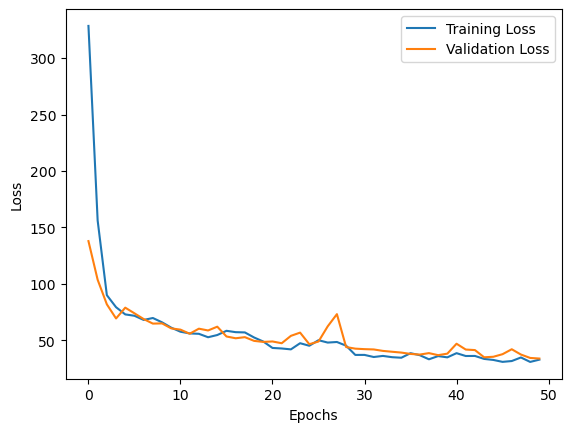

In [19]:
plot_history(history_1)

We can launch TensorBoard with:

- %tensorboard --logdir logs

or, from the command line:

- Navigate to the log directory:
    - cd path/to/logs (   in this example)
    
    
- Execute:
    - tensorboard --logdir /path/to/logs --port 8080
    
    
- Open the URL provided in the browser (e.g. http://localhost:8080).


After doing that, we will see something like this:

<br>

<img src="images/tb1.png" width="400"/>


<img src="images/tb3.png" width="500"/>

<a name="6.2"> </a>
### <font color='#2874a6'> 6.2. [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) </font>

Callback to save the Keras model or model weights at some frequency.

ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

A few important options:

- Whether to only keep the model that has achieved the "best performance" so far, or whether to save the model at the end of every epoch regardless of performance.

- Definition of "best"; which quantity to monitor and whether it should be maximized or minimized.

- The frequency it should save at. Currently, the callback supports saving at the end of every epoch, or after a fixed number of training batches.

- Whether only weights are saved, or the whole model is saved.

### Basic example

In [29]:
model_2 = build_compile_model()

model_2.fit(x_train,
          y_train,
          epochs=5, 
          validation_data=(x_test, y_test), 
          verbose=0,
          callbacks=[ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.h5', verbose=1),
          ])


Epoch 1: saving model to weights.01-167.34.h5

Epoch 2: saving model to weights.02-148.53.h5

Epoch 3: saving model to weights.03-73.71.h5

Epoch 4: saving model to weights.04-80.52.h5

Epoch 5: saving model to weights.05-75.27.h5


In the previous example:

- 'weights.{epoch:02d}-{val_loss:.2f}.h5' specifies the filename format for saving the model weights.

    - {epoch:02d}: The epoch number, padded to two digits (e.g., 01, 02, etc.).
    - {val_loss:.2f}: The validation loss, formatted to two decimal places.
    - .h5: The file format for the saved model weights.

- Example output filenames:
    - weights.01-0.45.h5
    - weights.02-0.43.h5

- verbose=1: This setting tells the callback to print a message whenever it saves the model weights (e.g., "Epoch 1: saving model...").

<img src="images/weights.png"/>

### Save only the best model

In [37]:
model_checkpoint_callback = ModelCheckpoint(
    filepath='models/model.keras',
    monitor='mae',
    mode='min',
    save_best_only=True) #it only saves when the model is considered the "best", according to the metric
                            # specified

model_3 = build_compile_model()

model_3.fit(x_train,
          y_train,
          epochs=5, 
          validation_data=(x_test, y_test), 
          verbose=0,
          callbacks=[model_checkpoint_callback,])

In [38]:
!ls models

model.keras


Now, we can resume the training with the best model so far.

In [40]:
# load the model

from tensorflow.keras.models import load_model

model = load_model('models/model.keras')

In [41]:
# resume training
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
13/13 [==============================] - 1s 11ms/step - loss: 82.4574 - mae: 6.7899 - val_loss: 88.9657 - val_mae: 7.1649
Epoch 2/5
13/13 [==============================] - 0s 4ms/step - loss: 78.3465 - mae: 6.2896 - val_loss: 83.3492 - val_mae: 6.8469
Epoch 3/5
13/13 [==============================] - 0s 4ms/step - loss: 73.9817 - mae: 6.0651 - val_loss: 81.8693 - val_mae: 6.7522
Epoch 4/5
13/13 [==============================] - 0s 4ms/step - loss: 72.2758 - mae: 5.9015 - val_loss: 80.4070 - val_mae: 6.7192
Epoch 5/5
13/13 [==============================] - 0s 4ms/step - loss: 76.1036 - mae: 6.1308 - val_loss: 79.0496 - val_mae: 6.6323


<a name="6.3"> </a>
### <font color='#2874a6'> 6.3. [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) </font>

Stop training when a monitored metric has stopped improving.

Is a technique used to prevent overfitting.

In [56]:
# a model that has likely overfit.
def build_compile_model_2():
    # Build a Sequential model
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=(x_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)
    ])
    
    # Compile
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model



model_4 = build_compile_model_2()

history_4 = model_4.fit(x_train,
          y_train,
          epochs=200, 
          verbose=0,
          validation_data=(x_test, y_test))

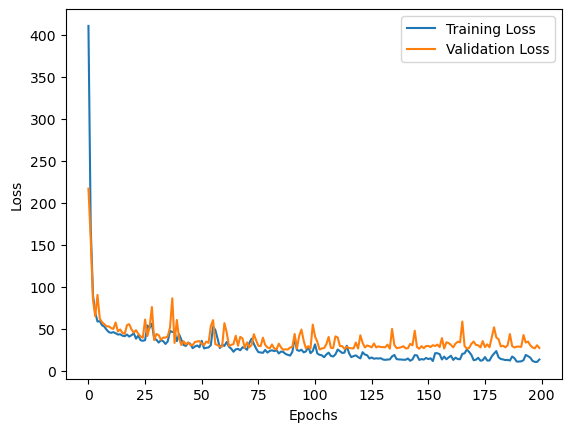

In [57]:
plot_history(history_4)

We can see that train_loss keeps improving, but val_loss remains essentially the same after a certain epoch, indicating overfitting. To address this problem, we will use early stopping.

In [58]:
model_5 = build_compile_model_2()

history_5 = model_5.fit(x_train,
          y_train,
          epochs=200, 
          verbose=0,
          validation_data=(x_test, y_test), 
          callbacks=[EarlyStopping(
              patience=20,
              mode='min',
              monitor='mae',
              restore_best_weights=True,
              verbose=1)
          ])

Restoring model weights from the end of the best epoch: 135.
Epoch 155: early stopping


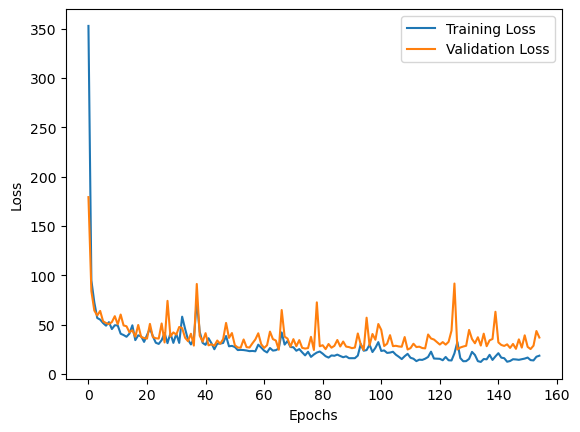

In [59]:
plot_history(history_5)

<a name="6.4"> </a>
### <font color='#2874a6'> 6.4. [CSVLogger](https://keras.io/api/callbacks/csv_logger/) </font>

Callback that streams epoch results to a CSV file.

In [69]:
csv_file = 'training.csv'

model_6 = build_compile_model()

model_6.fit(x_train, 
          y_train,
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[CSVLogger(csv_file)
          ])

Epoch 1/5
13/13 [==============================] - 1s 11ms/step - loss: 609.0625 - mae: 20.0688 - val_loss: 114.1128 - val_mae: 7.9899
Epoch 2/5
13/13 [==============================] - 0s 4ms/step - loss: 153.0893 - mae: 8.9472 - val_loss: 125.0509 - val_mae: 9.1971
Epoch 3/5
13/13 [==============================] - 0s 4ms/step - loss: 99.6982 - mae: 7.1387 - val_loss: 73.3321 - val_mae: 6.3033
Epoch 4/5
13/13 [==============================] - 0s 3ms/step - loss: 76.4988 - mae: 6.4595 - val_loss: 66.5354 - val_mae: 6.2386
Epoch 5/5
13/13 [==============================] - 0s 4ms/step - loss: 73.6290 - mae: 6.0481 - val_loss: 65.7098 - val_mae: 6.3835


In [70]:
pd.read_csv(csv_file).head()

,epoch,loss,mae,val_loss,val_mae
0,0,609.062500,20.068777,114.112785,7.989886
1,1,153.089310,8.947190,125.050896,9.197085
2,2,99.698242,7.138662,73.332130,6.303286
3,3,76.498795,6.459521,66.535431,6.238593
4,4,73.629044,6.048109,65.709793,6.383531


<a name="6.5"> </a>
### <font color='#2874a6'> 6.5. [LearningRateScheduler](https://keras.io/api/callbacks/learning_rate_scheduler/) </font>

At the beginning of every epoch, this callback gets the updated learning rate value from schedule function provided at `__init__`, with the current epoch and current learning rate, and applies the updated learning rate on the optimizer.

In [71]:
def step_decay(epoch):
    """
    Implements step decay learning rate schedule.

    Parameters:
    epoch (int): The current training epoch.

    Returns:
    float: The updated learning rate based on step decay.
    """
    
    initial_lr = 0.01  # Initial learning rate
    drop = 0.5  # Factor by which the learning rate decreases
    epochs_drop = 1  # Number of epochs after which the learning rate drops

    # Compute the new learning rate:
    # - `math.floor((1+epoch)/epochs_drop)`: Calculates how many times the drop should be applied
    # - `math.pow(drop, ...)`: Applies the drop factor
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))

    return lr  # Return the adjusted learning rate



lr_scheduler = LearningRateScheduler(step_decay, verbose=1)


model_7 = build_compile_model()



model_7.fit(x_train,
          y_train,
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[lr_scheduler,
                    TensorBoard(log_dir='./log_dir')])


Epoch 1: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/5
13/13 [==============================] - 1s 11ms/step - loss: 653.2048 - mae: 19.4462 - val_loss: 169.3789 - val_mae: 11.5986 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.0025.
Epoch 2/5
13/13 [==============================] - 0s 4ms/step - loss: 109.7638 - mae: 7.7836 - val_loss: 94.2806 - val_mae: 7.5267 - lr: 0.0025

Epoch 3: LearningRateScheduler setting learning rate to 0.00125.
Epoch 3/5
13/13 [==============================] - 0s 5ms/step - loss: 75.9270 - mae: 6.3810 - val_loss: 79.2914 - val_mae: 6.3231 - lr: 0.0012

Epoch 4: LearningRateScheduler setting learning rate to 0.000625.
Epoch 4/5
13/13 [==============================] - 0s 4ms/step - loss: 63.0368 - mae: 5.5482 - val_loss: 70.6670 - val_mae: 6.3127 - lr: 6.2500e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0003125.
Epoch 5/5
13/13 [==============================] - 0s 4ms/step - loss: 61.0127 - mae

<a name="6.6"> </a>
### <font color='#2874a6'> 6.6. [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) </font>

Reduce learning rate when a metric has stopped improving.

In [79]:
# callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_mae',  # Monitor validation MAE
    factor=0.2,         # Reduce learning rate by 20% when triggered
    verbose=1,          # Print a message when the learning rate is reduced
    patience=1,         # Wait for 1 epoch before reducing the learning rate if no improvement
    min_lr=0.001        # Lower bound for the learning rate
)


model_8 = build_compile_model()

model_8.fit(x_train,
            y_train,
            epochs=5, 
            verbose=2,
            validation_data=(x_test, y_test), 
            callbacks = [reduce_lr_callback,
                         TensorBoard(log_dir='./log_dir')])

Epoch 1/5
13/13 - 1s - loss: 6156.4536 - mae: 62.5782 - val_loss: 134.1384 - val_mae: 8.1418 - lr: 0.0010 - 744ms/epoch - 57ms/step
Epoch 2/5
13/13 - 0s - loss: 444.6784 - mae: 18.2704 - val_loss: 487.3578 - val_mae: 19.2790 - lr: 0.0010 - 41ms/epoch - 3ms/step
Epoch 3/5
13/13 - 0s - loss: 199.9634 - mae: 11.6683 - val_loss: 83.8700 - val_mae: 6.6094 - lr: 0.0010 - 45ms/epoch - 3ms/step
Epoch 4/5
13/13 - 0s - loss: 109.6271 - mae: 7.1106 - val_loss: 92.6744 - val_mae: 6.9231 - lr: 0.0010 - 50ms/epoch - 4ms/step
Epoch 5/5
13/13 - 0s - loss: 81.7958 - mae: 6.4070 - val_loss: 75.7478 - val_mae: 6.5476 - lr: 0.0010 - 44ms/epoch - 3ms/step


In this very simple example, it wasn't necessary.

<a name="7"> </a>
## <font color='blue'> 7. Custom callbacks </font>

A custom callback is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference.

### **Common Methods for Training/Testing/Predictions**
These methods are provided to be overridden for custom behavior during training, testing, and predicting:

- **`on_(train|test|predict)_begin(self, logs=None)`**  
  - Called at the beginning of `fit`, `evaluate`, or `predict`.

- **`on_(train|test|predict)_end(self, logs=None)`**  
  - Called at the end of `fit`, `evaluate`, or `predict`.

- **`on_(train|test|predict)_batch_begin(self, batch, logs=None)`**  
  - Called before processing each batch during training, testing, or predicting.  
  - `logs`: Contains `batch` (current batch number) and `size` (batch size).

- **`on_(train|test|predict)_batch_end(self, batch, logs=None)`**  
  - Called after processing each batch during training, testing, or predicting.  
  - `logs`: Contains the stateful metrics results.

---

### **Training-Specific Methods**
These methods are provided specifically for training:

- **`on_epoch_begin(self, epoch, logs=None)`**  
  - Called at the beginning of each epoch during training.

- **`on_epoch_end(self, epoch, logs=None)`**  
  - Called at the end of each epoch during training.


<a name="7.1"> </a>
### <font color='#2874a6'> 7.1. Simple Custom Callback </font>

Let's define a simple custom callback to track the start and end of every batch of data. During those calls, it prints the index of the current batch.

In [80]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_train_batch_begin(self, batch, logs=None):
        print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

    def on_train_batch_end(self, batch, logs=None):
        print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

In [88]:
model_9 = build_compile_model()

_ = model_9.fit(x_train, 
              y_train,
              batch_size=64,
              epochs=3,
              steps_per_epoch=5,
              verbose=0,
              validation_data=(x_test, y_test),
              callbacks=[MyCustomCallback()])

Training: batch 0 begins at 16:51:29.269130
Training: batch 0 ends at 16:51:29.711019
Training: batch 1 begins at 16:51:29.711525
Training: batch 1 ends at 16:51:29.712607
Training: batch 2 begins at 16:51:29.712793
Training: batch 2 ends at 16:51:29.713606
Training: batch 3 begins at 16:51:29.713776
Training: batch 3 ends at 16:51:29.714580
Training: batch 4 begins at 16:51:29.714745
Training: batch 4 ends at 16:51:29.715604
Training: batch 0 begins at 16:51:29.828727
Training: batch 0 ends at 16:51:29.829791
Training: batch 1 begins at 16:51:29.829990
Training: batch 1 ends at 16:51:29.830813
Training: batch 2 begins at 16:51:29.830998
Training: batch 2 ends at 16:51:29.831745
Training: batch 3 begins at 16:51:29.831928
Training: batch 3 ends at 16:51:29.832707
Training: batch 4 begins at 16:51:29.832878
Training: batch 4 ends at 16:51:29.833637
Training: batch 0 begins at 16:51:29.853701
Training: batch 0 ends at 16:51:29.854681
Training: batch 1 begins at 16:51:29.854855
Training: 

<a name="7.2"> </a>
### <font color='#2874a6'> 7.2. Detect overfitting </font>

In [97]:
class DetectOverfittingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.7):  # Default threshold set to 0.9 for detecting overfitting
        super(DetectOverfittingCallback, self).__init__()
        self.threshold = threshold  # Store the threshold for detecting overfitting

    def on_epoch_end(self, epoch, logs=None):
        # Calculate the ratio of validation MAE to training MAE at the end of each epoch
        ratio = logs["val_mae"] / logs["mae"]
        
        # Print the epoch and the ratio of validation to training loss (MAE)
        print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

        # If the ratio exceeds the threshold, consider it as overfitting and stop training
        if ratio > self.threshold:
            print("Stopping training...")  # Indicate that training is being stopped
            self.model.stop_training = True  # Stop the training process


In [98]:
model_10 = build_compile_model()

_ = model_10.fit(x_train, 
              y_train,
              batch_size=64,
              epochs=3,
              steps_per_epoch=5,
              verbose=0,
              validation_data=(x_test, y_test),
              callbacks=[DetectOverfittingCallback()])

Epoch: 0, Val/Train loss ratio: 0.55
Epoch: 1, Val/Train loss ratio: 0.78
Stopping training...


<a name="7.3"> </a>
### <font color='#2874a6'> 7.3. Visualize predictions </font>

For this example we will use an image dataset.

In [4]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [6]:
GIF_PATH = './animation.gif'

In [19]:
# Define a custom callback for visualizing model predictions during training
class VisCallback(tf.keras.callbacks.Callback):
    """
    A custom callback for visualizing model predictions on a random sample of data 
    after each epoch and saving the results as a GIF.

    Attributes:
    - inputs (numpy.array): Input data for testing the model.
    - ground_truth (numpy.array): True labels for the input data.
    - display_freq (int): Frequency (in epochs) at which to display the images.
    - n_samples (int): Number of samples to visualize in each epoch.
    """
    
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        """
        Initializes the VisCallback with the provided parameters.

        Parameters:
        - inputs (numpy.array): The input data for model predictions.
        - ground_truth (numpy.array): The actual labels corresponding to the input data.
        - display_freq (int, optional): How frequently (in epochs) to display the visualizations. Default is 10.
        - n_samples (int, optional): The number of random samples to display in each epoch. Default is 10.
        """
        self.inputs = inputs
        self.ground_truth = ground_truth
        self.images = []  # List to store the generated images for the GIF
        self.display_freq = display_freq  # Frequency of displaying the results
        self.n_samples = n_samples  # Number of random samples to visualize

    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch. Randomly samples data, makes predictions, 
        visualizes the results, and saves the images for later use.

        Parameters:
        - epoch (int): The current epoch number.
        - logs (dict, optional): A dictionary containing logs from the current epoch.
        """
        
        # Randomly sample data from the inputs and ground_truth
        indexes = np.random.choice(len(self.inputs), size=self.n_samples)
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        
        # Make predictions using the trained model
        predictions = np.argmax(self.model.predict(X_test), axis=1)

        # Plot and display the digits along with the predictions and ground truth
        display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

        # Save the generated figure to an in-memory buffer
        buf = io.BytesIO()  # Create an in-memory binary stream buffer
        plt.savefig(buf, format='png')  # Save the current plot as a PNG to the buffer
        buf.seek(0)  # Rewind the buffer to the beginning
        image = Image.open(buf)  # Open the image from the buffer
        self.images.append(np.array(image))  # Append the image to the list for GIF creation

        # Display the plot every 'display_freq' epochs
        if epoch % self.display_freq == 0:
            plt.show()

    def on_train_end(self, logs=None):
        """
        Called at the end of training. Saves all the collected images as a GIF.

        Parameters:
        - logs (dict, optional): A dictionary containing logs from the final training epoch.
        """
        # Save the list of images as a GIF with 1 frame per second
        imageio.mimsave(GIF_PATH, self.images, fps=1)


In [20]:
def build_compile_image_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='linear', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

<a name="references"> </a>
## <font color='blue'> 8. References </font>

[TensorFlow Advanced Techniques Specialization](https://www.coursera.org/specializations/tensorflow-advanced-techniques)

[Keras Documentation](https://keras.io/api/)